# Heart Disease Model Output Evaluation

Run `javac src/*.java && java -cp src Main` from the project root before using this notebook so that the latest artifacts exist under `../outputs/run_<timestamp>`.

This notebook will:
- Detect the most recent run folder
- Load the generated summary, predictions, and process log
- Visualize performance (confusion matrix, probability diagnostics)
- Highlight any process issues captured during training



In [1]:
from pathlib import Path

OUTPUTS_ROOT = (Path("..") / "outputs").resolve()


def get_latest_run_dir(root: Path) -> Path:
    if not root.exists():
        raise FileNotFoundError(
            f"Outputs directory not found at {root}. Run the Java pipeline first."
        )
    run_dirs = sorted([p for p in root.glob("run_*") if p.is_dir()])
    if not run_dirs:
        raise FileNotFoundError(
            f"No run_* directories were found under {root}. Generate a run and try again."
        )
    return run_dirs[-1]


run_dir = get_latest_run_dir(OUTPUTS_ROOT)
print(f"Using run directory: {run_dir}")



Using run directory: /Users/ogorpynich/Desktop/data466/heart-disease466/outputs/run_20251202_083202


In [2]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (8, 5), "axes.titlesize": 14})



In [3]:
summary_path = run_dir / "run_summary.json"
predictions_path = run_dir / "test_predictions.csv"
process_log_path = run_dir / "process_log.txt"

for path in (summary_path, predictions_path, process_log_path):
    if not path.exists():
        raise FileNotFoundError(f"Expected artifact missing: {path}")

with summary_path.open() as f:
    summary = json.load(f)

predictions = pd.read_csv(predictions_path)
predictions["correct"] = predictions["correct"].astype(str).str.lower().eq("true")
predictions["actual_label"] = predictions["actual"].map({0: "No Heart Disease", 1: "Heart Disease"})
predictions["prediction_label"] = predictions["prediction"].map({0: "No Heart Disease", 1: "Heart Disease"})

process_lines = process_log_path.read_text().splitlines()

print(f"Loaded {len(predictions):,} predictions and {len(process_lines):,} log lines.")
predictions.sample(5, random_state=42)



Loaded 3,200 predictions and 79 log lines.


,sample_index,prediction,actual,prob_heart_disease,confidence,correct,actual_label,prediction_label
2384,2384,1,0,0.727723,0.727723,False,No Heart Disease,Heart Disease
2538,2538,0,0,0.212871,0.787129,True,No Heart Disease,No Heart Disease
2176,2176,0,1,0.287129,0.712871,False,Heart Disease,No Heart Disease
897,897,1,1,0.995050,0.995050,True,Heart Disease,Heart Disease
214,214,1,1,0.955446,0.955446,True,Heart Disease,Heart Disease


## Run Summary



In [4]:
dataset_info = summary["dataset"]
hyperparams = summary["hyperparameters"]
train_metrics = summary["trainMetrics"]
test_metrics = summary["testMetrics"]
confusion = summary["testConfusionMatrix"]

rows = [
    ("Run ID", summary["runId"]),
    ("Timestamp", summary["timestamp"]),
    ("Dataset", dataset_info["path"]),
    ("Features", dataset_info["features"]),
    ("Train samples", dataset_info["trainSamples"]),
    ("Test samples", dataset_info["testSamples"]),
    ("numTrees", hyperparams["numTrees"]),
    ("maxDepth", hyperparams["maxDepth"]),
    ("minSamplesSplit", hyperparams["minSamplesSplit"]),
    ("maxFeatures", hyperparams["maxFeatures"]),
]
summary_df = pd.DataFrame(rows, columns=["Item", "Value"])
summary_df



,Item,Value
0,Run ID,run_20251202_083202
1,Timestamp,2025-12-02T08:32:02.751343
2,Dataset,python-analysis/artifacts/features_model_ready...
3,Features,20
4,Train samples,12800
5,Test samples,3200
6,numTrees,200
7,maxDepth,20
8,minSamplesSplit,10
9,maxFeatures,4


In [5]:
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1"],
    "Train": [train_metrics["accuracy"], train_metrics["precision"], train_metrics["recall"], train_metrics["f1"]],
    "Test": [test_metrics["accuracy"], test_metrics["precision"], test_metrics["recall"], test_metrics["f1"]],
})
metrics_df.style.format({"Train": "{:.4f}", "Test": "{:.4f}"})



,Metric,Train,Test
0,Accuracy,0.7915,0.7509
1,Precision,0.8179,0.7936
2,Recall,0.7476,0.6898
3,F1,0.7812,0.7381


## Confusion Matrix



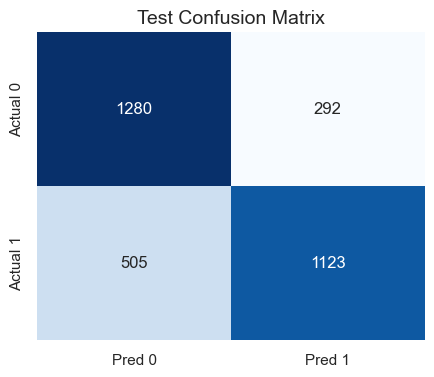

In [6]:
cm = np.array([
    [confusion["trueNegatives"], confusion["falsePositives"]],
    [confusion["falseNegatives"], confusion["truePositives"]],
])

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["Actual 0", "Actual 1"],
    ax=ax,
)
ax.set_title("Test Confusion Matrix")
plt.show()



## Prediction Quality Checks



In [7]:
def derive_metrics(df: pd.DataFrame) -> pd.Series:
    tp = ((df["prediction"] == 1) & (df["actual"] == 1)).sum()
    tn = ((df["prediction"] == 0) & (df["actual"] == 0)).sum()
    fp = ((df["prediction"] == 1) & (df["actual"] == 0)).sum()
    fn = ((df["prediction"] == 0) & (df["actual"] == 1)).sum()

    accuracy = (tp + tn) / len(df)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0

    return pd.Series({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn,
    })

metrics_from_predictions = derive_metrics(predictions)
metrics_from_predictions



accuracy        0.750938
precision       0.793640
recall          0.689803
f1              0.738087
tp           1123.000000
fp            292.000000
tn           1280.000000
fn            505.000000
dtype: float64

## Probability Diagnostics



/var/folders/8w/2jv4_2g55nxbchfk7bjxj1v00000gn/T/ipykernel_39766/2846346838.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions.assign(prob_bin=prob_bins)


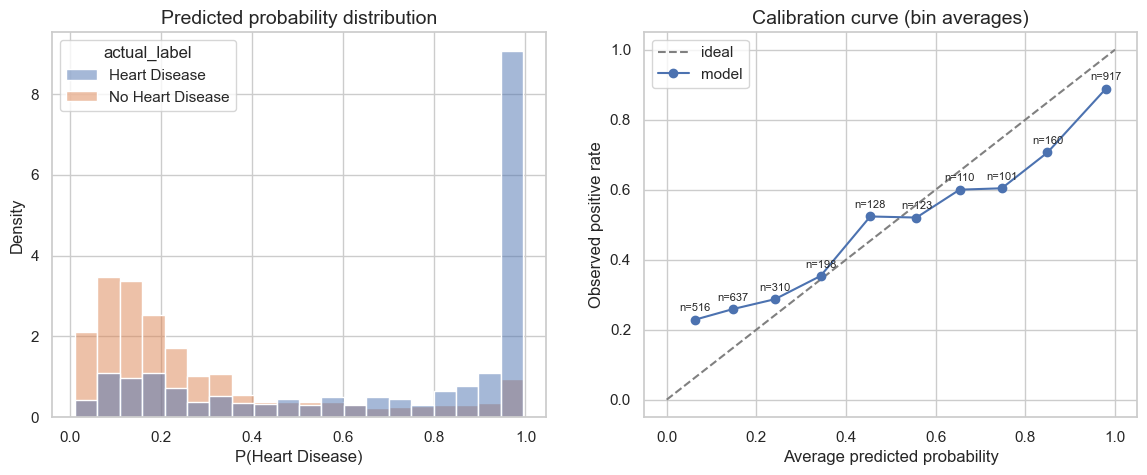

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(
    data=predictions,
    x="prob_heart_disease",
    hue="actual_label",
    bins=20,
    stat="density",
    common_norm=False,
    ax=axes[0],
)
axes[0].set_title("Predicted probability distribution")
axes[0].set_xlabel("P(Heart Disease)")

prob_bins = pd.cut(
    predictions["prob_heart_disease"],
    bins=np.linspace(0, 1, 11),
    include_lowest=True,
)
calibration = (
    predictions.assign(prob_bin=prob_bins)
    .groupby("prob_bin")
    .agg(
        avg_prob=("prob_heart_disease", "mean"),
        positive_rate=("actual", "mean"),
        count=("actual", "size"),
    )
    .dropna()
)
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="ideal")
axes[1].plot(
    calibration["avg_prob"],
    calibration["positive_rate"],
    marker="o",
    label="model",
)
axes[1].set_title("Calibration curve (bin averages)")
axes[1].set_xlabel("Average predicted probability")
axes[1].set_ylabel("Observed positive rate")
axes[1].legend()

for idx, row in calibration.iterrows():
    axes[1].annotate(
        f"n={int(row['count'])}",
        (row["avg_prob"], row["positive_rate"]),
        textcoords="offset points",
        xytext=(0, 6),
        ha="center",
        fontsize=8,
    )

plt.show()



## Process Timeline Snapshot



In [9]:
MAX_LINES = 40
num_lines = len(process_lines)
start = max(0, num_lines - MAX_LINES)
preview = process_lines[start:]

print(f"Showing the last {len(preview)} of {num_lines} log lines (folder: {run_dir.name})\n")
for line in preview:
    print(line)



Showing the last 40 of 79 log lines (folder: run_20251202_083202)

                0      1
Actual  0    1280   292
        1     505  1123
TP: 1123, FP: 292, TN: 1280, FN: 505

=== Training Set Evaluation (for comparison) ===
Accuracy:  0.7915
F1 Score: 0.7812
Precision:0.8179
Recall:   0.7476

Saving visualization of tree 0...
  Saved to: /Users/ogorpynich/Desktop/data466/heart-disease466/outputs/run_20251202_083202/tree_viz_0.dot

=== Detailed Predictions on First 5 Test Samples ===

Sample #1
  Prediction: Heart Disease (96.5% confidence)
  Actual:     Heart Disease
  Result:     CORRECT

Sample #2
  Prediction: Heart Disease (99.5% confidence)
  Actual:     No Heart Disease
  Result:     INCORRECT

Sample #3
  Prediction: Heart Disease (79.2% confidence)
  Actual:     No Heart Disease
  Result:     INCORRECT

Sample #4
  Prediction: Heart Disease (98.0% confidence)
  Actual:     No Heart Disease
  Result:     INCORRECT

Sample #5
  Prediction: No Heart Disease (90.1% confidence)
 